TensorFlow version: 2.10.0
Verfügbare Geräte: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
LunarLander-v2 erfolgreich erstellt!
Action Space: Discrete(4)
Observation Space: Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
Starte Training...
Episode 0, Durchschnittlicher Reward: -449.39
Episode 10, Durchschnittlicher Reward: -197.95
Episode 20, Durchschnittlicher Reward: -213.32
Episode 30, Durchschnittlicher Reward: -178.23
Episode 40, Durchschnittlicher Reward: -138.08
Episode 50, Durchschnittlicher Reward: -159.06
Episode 60, Durchschnittlicher Reward: -183.37
Episode 70, Durchschnittlicher Reward: -94.56
Episode 80, Durchschnittlicher Reward: -136.30
Episode 90, Durchschnittlicher Reward: -146.00
Episode 100, Durchschnittlicher Reward: -110.31
Episode 110, Durchschnittlicher Reward: -96.84
Episode 120, Durchschnittl

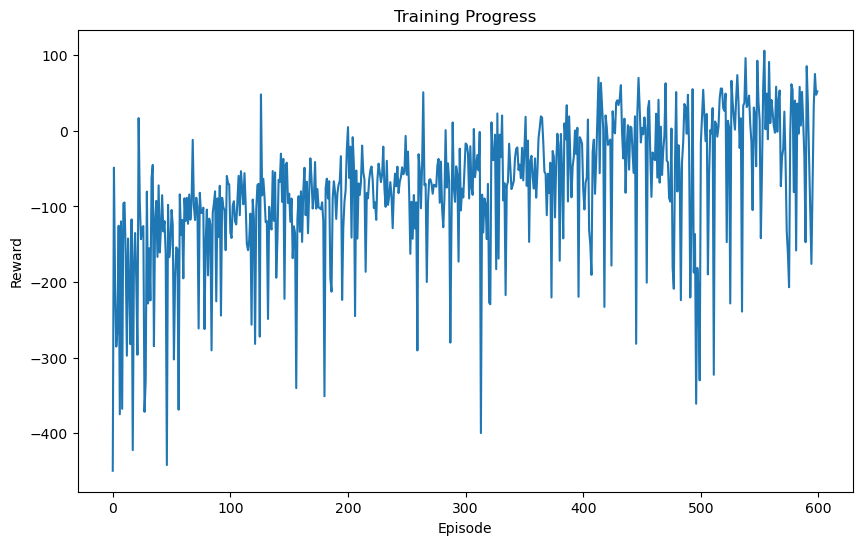

Nehme mehrere Test-Episoden auf...
Aufnahme 1/5, Reward: 17.12
Aufnahme 2/5, Reward: 6.01
Aufnahme 3/5, Reward: 55.73
Aufnahme 4/5, Reward: 44.15


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Aufnahme 5/5, Reward: 16.28
Video gespeichert als best_episode.mp4
Beste Episode mit Reward 55.73 wurde gespeichert


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video gespeichert als second_best_episode.mp4
Zweitbeste Episode mit Reward 44.15 wurde gespeichert
Video gespeichert als third_best_episode.mp4
Drittbeste Episode mit Reward 17.12 wurde gespeichert


In [ ]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import imageio
from pathlib import Path
import base64
from IPython.display import HTML, display

# Sicherstellen, dass TensorFlow korrekt läuft
print(f"TensorFlow version: {tf.__version__}")
print(f"Verfügbare Geräte: {tf.config.list_physical_devices()}")

# Policy Netzwerk definieren
class PolicyNetwork(keras.Model):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.dense3 = layers.Dense(action_dim)
    #forward pass    
    def call(self, states):
        x = self.dense1(states)
        x = self.dense2(x)
        logits = self.dense3(x)
        return logits
    #wahscheinliche Verteilung der Aktionen
    def action_distribution(self, states):
        logits = self.call(states)
        return tfp.distributions.Categorical(logits=logits)
    #action wählen
    def sample_action(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        distribution = self.action_distribution(state)
        action = distribution.sample()
        return int(action.numpy()[0])

# REINFORCE Algorithmus
def reinforce(env, policy, optimizer, n_episodes, gamma=0.99):
    episode_rewards = []
    
    for episode in range(n_episodes):
        states = []
        actions = []
        rewards = []
        
        state, _ = env.reset()
        done = False
        episode_reward = 0
        
        # Trajektorie sammeln
        while not done:
            # Aktion auswählen
            state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
            distribution = policy.action_distribution(state_tensor)
            action = distribution.sample().numpy()[0]
            
            # Aktion ausführen
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Speichern
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            
            episode_reward += reward
            state = next_state
        
        episode_rewards.append(episode_reward)
        
        # Returns berechnen
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + gamma * G
            returns.insert(0, G)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)
        
        # Normalisierung der Returns (hilft bei stabilerem Training)
        if len(returns) > 1:  # Verhindere Division durch 0
            returns = (returns - tf.reduce_mean(returns)) / (tf.math.reduce_std(returns) + 1e-8)
        
        # Policy Gradient Update
        with tf.GradientTape() as tape:
            states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
            actions_tensor = tf.convert_to_tensor(actions, dtype=tf.int32)
            
            distribution = policy.action_distribution(states_tensor)
            log_probs = distribution.log_prob(actions_tensor)
            
            loss = -tf.reduce_sum(log_probs * returns)
        
        gradients = tape.gradient(loss, policy.trainable_variables)
        optimizer.apply_gradients(zip(gradients, policy.trainable_variables))
        
        # Fortschritt ausgeben
        if episode % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
            print(f"Episode {episode}, Durchschnittlicher Reward: {avg_reward:.2f}")
    
    return episode_rewards

# Funktion zum Aufnehmen mehrerer Episoden und Auswahl der Besten
def record_best_episodes(env, policy, num_attempts=10):
    episodes = []
    
    for i in range(num_attempts):
        state, _ = env.reset()
        frames = []
        done = False
        total_reward = 0
        
        while not done:
            frames.append(env.render())
            action = policy.sample_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state
        
        episodes.append((total_reward, frames))
        print(f"Aufnahme {i+1}/{num_attempts}, Reward: {total_reward:.2f}")
    
    # Nach Reward sortieren (absteigend)
    episodes.sort(key=lambda x: x[0], reverse=True)
    
    return episodes

# Funktion zum Speichern des Videos
def save_video(frames, filename="agent_video.mp4", fps=30):
    imageio.mimsave(filename, frames, fps=fps)
    print(f"Video gespeichert als {filename}")
    return filename

# Funktion zum Anzeigen des Videos
def show_video(path):
    mp4 = Path(path)
    if mp4.exists():
        video_b64 = base64.b64encode(mp4.read_bytes())
        html = f"""
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{video_b64.decode()}" type="video/mp4">
        </video>
        """
        return HTML(html)
    else:
        print(f"Video-Datei {path} nicht gefunden!")
        return None

# Hauptfunktion
def main():
    # Umgebung erstellen
    try:
        env = gym.make("LunarLander-v2", render_mode="rgb_array")
        print("LunarLander-v2 erfolgreich erstellt!")
    except Exception as e:
        print(f"Fehler beim Erstellen der Umgebung: {e}")
        print("Verwende stattdessen CartPole als Fallback.")
        env = gym.make("CartPole-v1", render_mode="rgb_array")
    
    # Umgebungsinformationen ausgeben
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    
    # Policy Network erstellen
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    policy = PolicyNetwork(state_dim, action_dim)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    
    # Training
    print("Starte Training...")
    n_episodes = 600 
    rewards = reinforce(env, policy, optimizer, n_episodes)
    
    # Reward-Plot
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress')
    plt.savefig('learning_curve.png')
    plt.show()
    
    # Mehrere Episoden aufnehmen und die besten auswählen
    print("Nehme mehrere Test-Episoden auf...")
    best_episodes = record_best_episodes(env, policy, num_attempts=5)
    
    # Beste Episode speichern und anzeigen
    best_reward, best_frames = best_episodes[0]
    video_path = save_video(best_frames, "best_episode.mp4")
    print(f"Beste Episode mit Reward {best_reward:.2f} wurde gespeichert")
    
    # Video anzeigen
    video_player = show_video(video_path)
    if video_player:
        display(video_player)
    
    # Optional: Auch die zweit- und drittbesten Episoden speichern
    if len(best_episodes) > 1:
        second_best_reward, second_best_frames = best_episodes[1]
        save_video(second_best_frames, "second_best_episode.mp4")
        print(f"Zweitbeste Episode mit Reward {second_best_reward:.2f} wurde gespeichert")
    
    if len(best_episodes) > 2:
        third_best_reward, third_best_frames = best_episodes[2]
        save_video(third_best_frames, "third_best_episode.mp4")
        print(f"Drittbeste Episode mit Reward {third_best_reward:.2f} wurde gespeichert")
    
    # Umgebung schließen
    env.close()

if __name__ == "__main__":
    main()

Welche Aktionen sind möglich?
In LunarLander-v2 gibt es 4 diskrete Aktionen:

0: Nichts tun
1: Linkes Triebwerk feuern (schiebt das Raumschiff nach rechts)
2: Haupttriebwerk feuern (schiebt das Raumschiff nach oben)
3: Rechtes Triebwerk feuern (schiebt das Raumschiff nach links)

Wie sieht der Observation Space aus?
Der Observation Space besteht aus einem 8-dimensionalen Vektor mit folgenden Komponenten:

x-Position des Landers (horizontal)
y-Position des Landers (vertikal)
x-Geschwindigkeit des Landers
y-Geschwindigkeit des Landers
Winkel des Landers
Winkelgeschwindigkeit des Landers
Boolesch: Ist das linke Bein in Kontakt mit dem Boden?
Boolesch: Ist das rechte Bein in Kontakt mit dem Boden?


Wie sieht der Rewards Space aus?
Der Agent erhält in LunarLander-v2 folgende Belohnungen:

Landungsbelohnung: +100 bis +140 Punkte für eine erfolgreiche Landung zwischen den Fähnchen
Entfernung vom Landeplatz: -0.3 Punkte pro Zeitschritt, basierend auf der Entfernung zum Landeplatz
Absturzstrafe: -100 Punkte für einen Absturz
Sanfte Landung: +100 Punkte für eine Landung mit geringer Geschwindigkeit
Triebwerksstrafe:
-0.3 Punkte für jedes Einschalten des Haupttriebwerks
-0.03 Punkte für jedes Einschalten der Seitentriebwerke
Kontaktbelohnung: +10 Punkte wenn beide Beine Bodenkontakt haben

